### ID3 算法手撕实现

In [4]:
import numpy as np

class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class  # 预测的类别
        self.feature_index = 0  # 特征索引
        self.threshold = 0  # 阈值
        self.left = None  # 左子树
        self.right = None  # 右子树

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # 决策树的最大深度

    def fit(self, X, y):
        self.n_classes_ = len(set(y))  # 类别的数量
        self.n_features_ = X.shape[1]  # 特征的数量
        self.tree_ = self._grow_tree(X, y)  # 构建决策树

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]  # 对输入数据进行预测
    
    def _best_gini_split(self, X, y):
        m = y.size  # 样本的数量
        if m <= 1:  # 如果样本数量小于等于1，无法进行分割
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]  # 每个类别在父节点中的样本数量
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)  # 父节点的基尼指数
        best_idx, best_thr = None, None  # 最佳分割特征索引和阈值
        for idx in range(self.n_features_):  # 遍历每个特征
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))  # 根据特征值对样本进行排序
            num_left = [0] * self.n_classes_  # 左子节点中每个类别的样本数量
            num_right = num_parent.copy()  # 右子节点中每个类别的样本数量，初始值为父节点的样本数量
            for i in range(1, m):  # 遍历每个样本
                c = classes[i - 1]  # 样本的类别
                num_left[c] += 1  # 更新左子节点中对应类别的样本数量
                num_right[c] -= 1  # 更新右子节点中对应类别的样本数量
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )  # 左子节点的基尼指数
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )  # 右子节点的基尼指数
                gini = (i * gini_left + (m - i) * gini_right) / m  # 加权平均的基尼指数
                if thresholds[i] == thresholds[i - 1]:  # 如果特征值相同，则跳过（特征阈值）
                    continue
                if gini < best_gini:  # 如果基尼指数更小，则更新最佳分割特征索引和阈值 （循环每个特征，和每个阈值，以求解最优分类
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr  # 返回最佳分割特征索引和阈值

    def _best_gain_split(self, X, y):
        m = y.size  # 样本的数量
        if m <= 1:  # 如果样本数量小于等于1，无法进行分割
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]  # 计算每个类别的样本数量
        best_gain = -1  # 初始化最佳信息增益
        best_idx, best_thr = None, None  # 初始化最佳特征索引和阈值
        for idx in range(self.n_features_):  # 遍历每个特征
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))  # 对每个特征值和类别标签进行排序
            num_left = [0] * self.n_classes_  # 初始化左子树的类别数量 (左边都是0,为0时自动计算为0） 
            num_right = num_parent.copy()  # 右子树的类别数量初始化为父节点的类别数量 (右边是全部）
            for i in range(1, m):  # 遍历每个样本
                c = classes[i - 1]  # 获取当前样本的类别
                num_left[c] += 1  # 左子树的类别数量增加
                num_right[c] -= 1  # 右子树的类别数量减少
                entropy_parent = -sum((num / m) * np.log2(num / m) for num in num_parent if num != 0)  # 计算父节点的熵
                entropy_left = -sum((num / i) * np.log2(num / i) for num in num_left if num != 0)  # 计算左子树的熵
                entropy_right = -sum((num / (m - i)) * np.log2(num / (m - i)) for num in num_right if num != 0)  # 计算右子树的熵
                gain = entropy_parent - (i * entropy_left + (m - i) * entropy_right) / m  # 计算信息增益（分类后左右的信息熵最小）
                if thresholds[i] == thresholds[i - 1]:  # 如果当前样本的特征值和前一个样本的特征值相同，跳过（不一样才能分界）
                    continue
                if gain > best_gain:  # 如果当前的信息增益大于最佳信息增益
                    best_gain = gain  # 更新最佳信息增益
                    best_idx = idx  # 更新最佳特征索引
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # 更新最佳阈值 （循环每个样本的值，根据两份数据均值确定阈值，一直循环）
        return best_idx, best_thr  # 返回最佳特征索引和阈值

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]  # 计算每个类别的样本数量
        predicted_class = np.argmax(num_samples_per_class)  # 预测的类别为样本数量最多的类别 （即确定分到该分支样本最多的记为该类）
        node = Node(predicted_class=predicted_class)  # 创建节点
        if depth < self.max_depth:  # 如果当前深度小于最大深度
            idx, thr = self._best_gain_split(X, y)  # 计算最佳分割
            if idx is not None:  # 如果存在最佳分割
                indices_left = X[:, idx] < thr  # 左子树的样本索引 (第 idx特征中小于thr阈值的索引)
                X_left, y_left = X[indices_left], y[indices_left]  # 左子树的样本
                X_right, y_right = X[~indices_left], y[~indices_left]  # 右子树的样本
                node.feature_index = idx  # 设置节点的特征索引
                node.threshold = thr  # 设置节点的阈值
                node.left = self._grow_tree(X_left, y_left, depth + 1)  # 构建左子树
                node.right = self._grow_tree(X_right, y_right, depth + 1)  # 构建右子树
        return node  # 返回节点

    def _predict(self, inputs):
        node = self.tree_  # 获取决策树的根节点
        while node.left:  # 如果存在左子树
            if inputs[node.feature_index] < node.threshold:  # 如果输入样本的特征值小于阈值
                node = node.left  # 到左子树
            else:
                node = node.right  # 到右子树
        return node.predicted_class  # 返回预测的类别

# 数据集
X = [[25, 1, 30000],
     [35, 0, 40000],
     [45, 0, 80000],
     [20, 1, 10000],
     [55, 1, 60000],
     [60, 0, 90000],
     [30, 1, 50000],
     [40, 0, 75000]]

Y = [0, 0, 1, 0, 1, 1, 0, 1]

# 创建决策树模型
clf = DecisionTree(max_depth=2)

# 训练模型
clf.fit(np.array(X), np.array(Y))

# 预测
print(clf.predict([[40, 0, 75000],[10, 0, 75000]]))  # 输出：[1, 0]

[1, 0]


处理数据

In [19]:
idx = 1
X = [[25, 1, 30000],
     [35, 0, 40000],
     [45, 0, 80000],
     [20, 1, 10000],
     [55, 1, 60000],
     [60, 0, 90000],
     [30, 1, 50000],
     [40, 0, 75000]]

Y = [0, 0, 1, 0, 1, 1, 0, 1]
X,y = np.array(X), np.array(Y)

print(zip(X[:, idx], y))
print(sorted(zip(X[:, idx], y))) # return list
print(*sorted(zip(X[:, idx], y))) # unpacks list  print data format is the zip format
# print(type(*sorted(zip(X[:, idx], y))))
print(zip(*sorted(zip(X[:, idx], y))))

[(0, 0), (0, 1), (0, 1), (0, 1), (1, 0), (1, 0), (1, 0), (1, 1)]
(0, 0) (0, 1) (0, 1) (0, 1) (1, 0) (1, 0) (1, 0) (1, 1)


### 使用sklearn库实现ID3算法

In [10]:
from sklearn import tree
import numpy as np

# 数据集
X = np.array([[25, 1, 30000],
              [35, 0, 40000],
              [45, 0, 80000],
              [20, 1, 10000],
              [55, 1, 60000],
              [60, 0, 90000],
              [30, 1, 50000],
              [40, 0, 75000]])

Y = np.array([0, 0, 1, 0, 1, 1, 0, 1])

# 创建决策树模型
clf = tree.DecisionTreeClassifier()

# 训练模型
clf = clf.fit(X, Y)

# 预测
print(clf.predict([[40, 0, 75000],[10, 0, 75000]]))  # 输出：[1, 0]

[1 0]


### C4.5算法手撕实现

In [2]:
import numpy as np

class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class  # 预测的类别
        self.feature_index = 0  # 特征索引
        self.threshold = 0  # 阈值（或切片） 
        self.left = None  # 左子树
        self.right = None  # 右子树

class DecisionTreeC4_5:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth  # 决策树的最大深度

    def fit(self, X, y):
        self.n_classes_ = len(set(y))  # 类别的数量
        self.n_features_ = X.shape[1]  # 特征的数量
        self.tree_ = self._grow_tree(X, y)  # 构建决策树

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]  # 对输入数据进行预测
    
    def _best_split(self, X, y):
        m = y.size  # 样本的数量
        if m <= 1:  # 如果样本数量小于等于1，无法进行分割
            return None, None
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]  # 每个类别在父节点中的样本数量
        best_gain_ratio = -1  # 最佳信息增益比
        best_idx, best_thr = None, None  # 最佳分割特征索引和阈值
        for idx in range(self.n_features_):  # 遍历每个特征
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))  # 根据特征值对样本进行排序
            num_left = [0] * self.n_classes_  # 左子节点中每个类别的样本数量
            num_right = num_parent.copy()  # 右子节点中每个类别的样本数量，初始值为父节点的样本数量
            for i in range(1, m):  # 遍历每个样本
                c = classes[i - 1]  # 样本的类别
                num_left[c] += 1  # 更新左子节点中对应类别的样本数量
                num_right[c] -= 1  # 更新右子节点中对应类别的样本数量
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )  # 左子节点的基尼指数
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )  # 右子节点的基尼指数
                gini = (i * gini_left + (m - i) * gini_right) / m  # 加权平均的基尼指数
                if thresholds[i] == thresholds[i - 1]:  # 如果特征值相同，则跳过（特征阈值）
                    continue
                info_gain = self._information_gain(gini, num_parent, num_left, num_right)  # 计算信息增益
                split_info = self._split_information(num_left, num_right)  # 计算分裂信息
                gain_ratio = info_gain / split_info  # 计算信息增益比
                if gain_ratio > best_gain_ratio:  # 如果信息增益比更大，则更新最佳分割特征索引和阈值
                    best_gain_ratio = gain_ratio
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr  # 返回最佳分割特征索引和阈值
    
    def _information_gain(self, gini, num_parent, num_left, num_right):
        m = sum(num_parent)  # 父节点的样本数量
        info_gain = gini  # 初始化信息增益
        for num, num_l, num_r in zip(num_parent, num_left, num_right):
            p = num / m  # 类别在父节点中的概率
            if num != 0:
                info_gain -= p * (1.0 - num_l / num)  # 左子节点的信息增益
            if num != m:
                info_gain -= p * (1.0 - num_r / num)  # 右子节点的信息增益
        return info_gain

    def _split_information(self, num_left, num_right):
        m = sum(num_left) + sum(num_right)  # 左右子节点的样本总数量
        split_info = 0
        for num in num_left + num_right:
            p = num / m  # 子节点中某一类别的概率
            if p > 0:
                split_info -= p * np.log2(p)  # 分裂信息
        return split_info

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]  # 每个类别的样本数量
        predicted_class = np.argmax(num_samples_per_class)  # 预测的类别为样本数量最多的类别
        node = Node(predicted_class)

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)  # 找到最佳分割特征索引和阈值
            if idx is not None:
                indices_left = X[:, idx] < thr  # 左子节点的样本索引
                X_left, y_left = X[indices_left], y[indices_left]  # 左子节点的样本和类别
                X_right, y_right = X[~indices_left], y[~indices_left]  # 右子节点的样本和类别
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)  # 递归构建左子树
                node.right = self._grow_tree(X_right, y_right, depth + 1)  # 递归构建右子树
        return node

    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:  # 根据特征值和阈值判断样本的类别
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [4]:
X = np.array([[2, 5], [3, 6], [4, 7], [5, 9], [6, 8], [7, 1]])
y = np.array([0, 0, 0, 1, 1, 1])

trees = DecisionTreeC4_5(max_depth=2)
trees.fit(X, y)

test_X = np.array([[4.5, 6.5], [6.2, 2.5]])
pred = trees.predict(test_X)
print(pred)

[1, 0]


### 决策树可视化

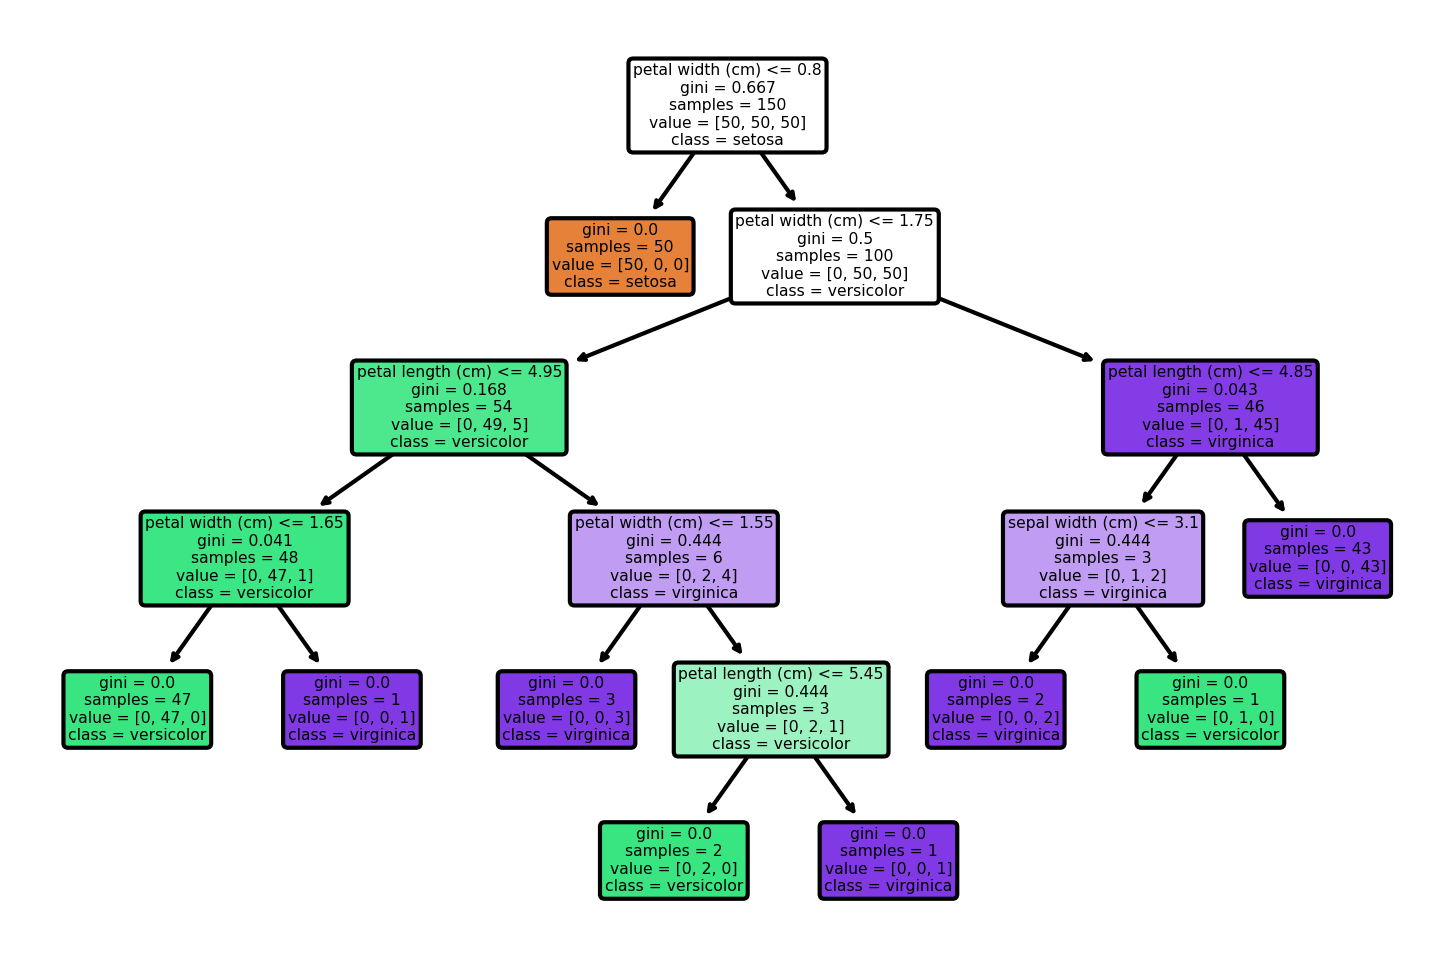

In [28]:
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

def visualize_decision_tree(decision_tree, feature_names, class_names):
    plt.figure(dpi=300)
    tree.plot_tree(decision_tree, feature_names=feature_names, class_names=class_names,
                   filled=True, rounded=True)
    plt.show()
clf = tree.DecisionTreeClassifier(random_state=0)
iris = load_iris()
clf = clf.fit(iris.data, iris.target)
visualize_decision_tree(clf,feature_names = iris.feature_names, class_names = iris.target_names)